# WGAN

A short easy to read implementation of a Wasserstein GAN on CIFAR10 data.

Origional paper: https://arxiv.org/abs/1701.07875

Many tips and improvements: https://arxiv.org/abs/1704.00028

If you don't have access to a GPU you will have to manually remove all calls of the PyTorch '.cuda()' method before running.

Also I would like to draw your attention to this repository, https://github.com/caogang/wgan-gp, which was a lot of help in diagnosing problems in my code.

In [1]:
#Import Libraries

import numpy as np

import torch
import torch.nn as nn
import torch.autograd as ag
import torch.functional as F
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

Some defines, the batch size was chosen since it's the largest my GPU can handle without running out of memory.

In [2]:
noise_dim = 128
n_channels = 3
img_shape = 32
batch_size = 200

Import the CIFAR10 data and define preprocessing transformation

In [3]:
transform = transforms.Compose([
    transforms.Resize((img_shape, img_shape)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CIFAR10(root='./CIFAR10', transform = transform, download = True)

Files already downloaded and verified


Define the generator and discriminator networks.

I found an huge increase in performance after implementing the recomendations from https://arxiv.org/abs/1511.06434. In particular replacing pooling layers with strided convolutional layers was extremely useful. I normally like to use an adaptive pooling layer at the end of a CNN rather than manually unrolling the last convolutional layer, so that the classifier is agnostic as to the size of the input, but that seemed to perform very badly here.

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim = noise_dim, img_shape = img_shape, n_channels = n_channels):
        super().__init__()
        n_feats = 64
        
        
        self.feats = nn.Sequential(
            nn.Linear(noise_dim, 4 * n_feats * 4 * 4),
            nn.ReLU(),
        )
        
        self.layers = []
        
        self.layers.append(nn.ConvTranspose2d(n_feats * 4, n_feats * 2, 2, stride = 2))
        self.layers.append(nn.BatchNorm2d(n_feats * 2))
        self.layers.append(nn.ReLU())
        
        self.layers.append(nn.ConvTranspose2d(n_feats * 2, n_feats, 2, stride = 2))
        self.layers.append(nn.BatchNorm2d(n_feats))
        self.layers.append(nn.ReLU())
        
        self.layers.append(nn.ConvTranspose2d(n_feats, n_channels, 2, stride = 2))
        self.layers.append(nn.Tanh())
        
        self.n_feats = n_feats
        
        self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        x = self.feats(x)
        x = x.view(-1, 4 * self.n_feats, 4, 4)
        
        for layer in self.layers:
            x = layer(x)
        
        return x

class Discriminator(nn.Module):
    def __init__(self, n_channels = n_channels, n_feats = 64):
        super().__init__()
        n_feats = 64
        self.n_feats = n_feats
        
        self.layers = []
        
        self.layers.append(nn.Conv2d(n_channels, n_feats, 3, stride = 2, padding = 1))
        self.layers.append(nn.BatchNorm2d(n_feats))
        self.layers.append(nn.LeakyReLU())
        
        self.layers.append(nn.Conv2d(n_feats, 2*n_feats, 3, stride = 2, padding = 1))
        self.layers.append(nn.BatchNorm2d(2*n_feats))
        self.layers.append(nn.LeakyReLU())
        
        self.layers.append(nn.Conv2d(2*n_feats, 4*n_feats, 3, stride = 2, padding = 1))
        self.layers.append(nn.BatchNorm2d(4*n_feats))
        self.layers.append(nn.LeakyReLU())
        
        self.layers = nn.ModuleList(self.layers)
        
        self.lin = nn.Linear(4*n_feats*4*4, 1)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        x = x.view(x.size(0), 4*self.n_feats*4*4)
        
        return self.lin(x)

Send generator and discriminator to the GPU

In [5]:
gen = Generator().cuda()
dis = Discriminator().cuda()

Define the number of discriminator steps for each generator step and the optimisation hyperparameters

In [6]:
num_disc_steps = 5

lr = 0.0001
betas = (0.5, 0.9)
lam = 10

We use the adam optimiser after the second paper referenced at the top.

In [7]:
dis_opt = optim.Adam(dis.parameters(), lr = lr, betas = betas)
gen_opt = optim.Adam(gen.parameters(), lr = lr, betas = betas)

Gradient penalty term

In [8]:
def grad_pen(dis, real, fake):
    alpha = torch.rand(real.size(0), 1).cuda()
    alpha = alpha.expand(real.size(0), 3*32*32)
    alpha = alpha.view(real.shape)
    
    interpolated_data = alpha * real.detach() + (1-alpha)*fake.detach()
    interpolated_data.cuda().requires_grad_(True)
    
    dis_inter = dis(interpolated_data)
    
    grads = ag.grad(dis_inter, interpolated_data, 
                   grad_outputs = torch.ones(dis_inter.size()).cuda(),
                   create_graph = True,
                   retain_graph = True,
                   only_inputs = True)[0]
    
    grads = grads.view(grads.size(0), -1)
    
    return ((grads.norm(2, dim = 1) - 1)**2).mean()

In [9]:
dis_loss_signal = []
gen_loss_signal = []

Training loop. It took ~1000 epochs in total to get reasonable looking results.

In [11]:
num_epochs = 500

for epoch in tqdm(range(num_epochs)):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True)
    for i, data in enumerate(dataloader):
        real, _ = data
        real = real.cuda()
        
        for param in dis.parameters():
            param.requires_grad = True
        
        dis.zero_grad()
        
        noise = torch.randn(real.size(0), noise_dim).cuda()
        
        ims_fake = gen(noise)
        ims_fake.detach()
        
        dis_fake = dis(ims_fake)
        dis_real = dis(real)
        
        real_loss = torch.mean(dis_real)
        
        fake_loss = torch.mean(dis_fake)
        
        grad_pen_loss = grad_pen(dis, real, ims_fake)*lam
        
        dis_loss = -real_loss+fake_loss+grad_pen_loss
        dis_loss.backward()
        
        dis_opt.step()
        
        dis_loss_signal += [dis_loss.detach().cpu().numpy()]
        
#        for param in dis.parameters():
#            param.data.clamp_(-0.01, 0.01)
        
        del real, noise, dis_fake, dis_real, dis_loss, ims_fake
        
        if i % num_disc_steps == 0:
            for param in dis.parameters():
                param.requires_grad = False
            
            gen.zero_grad()
            
            noise = torch.randn(batch_size, noise_dim).cuda().detach()
            gen_loss = -torch.mean(dis(gen(noise)))
            
            gen_loss.backward()
            gen_opt.step()
            
            gen_loss_signal += [gen_loss.detach().cpu().numpy()]
            
            del noise, gen_loss
        
#        if i % 10 == 0:
#            print("minibatch: ", i)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Discriminator Loss

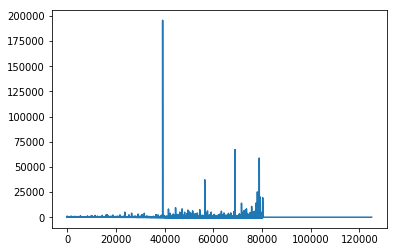

In [12]:
plt.plot(dis_loss_signal)
plt.show()

Generator Loss

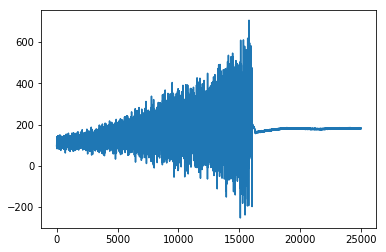

In [13]:
plt.plot(gen_loss_signal)
plt.show()

Save/Load

In [14]:
torch.save(gen.state_dict(), 'WGAN_gen_weights.pth')
torch.save(dis.state_dict(), 'WGAN_dis_weights.pth')

In [10]:
dis.load_state_dict(torch.load('WGAN_dis_weights.pth'))
gen.load_state_dict(torch.load('WGAN_gen_weights.pth'))

Some examples of generated images

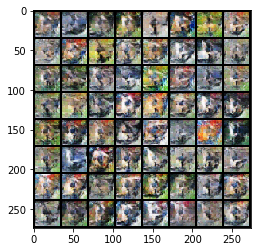

In [15]:
noise = torch.rand(64, noise_dim).cuda()

fake_ims = gen(noise)
grid = make_grid(0.5*fake_ims.data+0.5).cpu()

plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()

Looks ok except there is clearly a lot of mode collapse going on

And some examples of real images for comparison

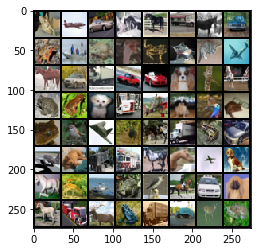

In [16]:
real = next(iter(dataloader))[0][:64]

grid = make_grid(0.5*real.data+0.5).cpu()

plt.imshow(grid.permute(1, 2, 0).numpy())
plt.show()